In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

sys.path.append('../../benchmarks_known/')
from benchmark_functions import (
        DejongConstr, 
        BraninConstr, 
        HyperEllipsoidConstr, 
        StyblinskiTangConstr,
)

sns.set(style='ticks', context='notebook', font_scale=1.2)

In [2]:
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])
plt.register_cmap(cmap=_cmap)
plt.register_cmap(cmap=_cmap_r)

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='golem'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_constr_surface(surface, ax=None, N=100):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap='golem')
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)
    
    params = [{'x0':x[0], 'x1':x[1]} for x in X]
    y_feas = surface.eval_constr(params)
    Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
    ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='nearest')

         x0        x1         obj
0  0.014974  0.007692 -280.577586
1  0.578884  0.651853  -63.982163
2  0.366982  0.507009  -24.047923
3  0.181924  0.343968  -30.040887
4  0.438987  0.074144  -17.101579
PASS


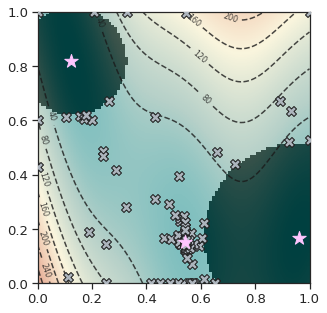

In [3]:
surface = BraninConstr()

# with open('../../benchmarks_known/branin/opt_adam/results.pkl', 'rb') as content:
#     data = pickle.load(content)

with open('../../benchmarks_known/branin/dragonfly/results.pkl', 'rb') as content:
    data = pickle.load(content)

print(data[0].head())
    
# ------------   
# sanity check
# ------------
allgood = True
for df in data:
    x0_arr = df.loc[:, 'x0'].to_numpy()
    x1_arr = df.loc[:, 'x1'].to_numpy()
    for X in np.array([x0_arr, x1_arr]).T:
        feas = surface.eval_constr({'x0':X[0], 'x1':X[1]})
        if feas is False:
            allgood = False
            
if allgood is False:
    print(f"FAILED!")
else:
    print('PASS')
# ------------

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plot_constr_surface(surface, ax=ax, N=100)

n = 2
X = data[n].loc[:, ['x0', 'x1']]

_ = ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

In [4]:
def get_traces_min(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)


def get_traces_min_for_categorical(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = np.zeros(100)  # up to 100
        results = df.loc[:, 'obj'].to_numpy()[:100]  # up to 100
        trace[:len(results)] = results
        
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)


def plot_min_trace_mean(data, ax=None, color=None, label=None, categorical=False, shift=0.0):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    if categorical is True:
        traces_min = get_traces_min_for_categorical(data) - shift
    else:
        traces_min = get_traces_min(data) - shift
    
    mean = np.nanmean(traces_min, axis=0)
    stde = np.nanstd(traces_min, axis=0, ddof=1) / np.sqrt(np.shape(traces_min)[0] - 1)
    x = range(1, np.shape(traces_min)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=5)
    ax.plot(x, mean, color=color, linewidth=4, label=label)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5)
    
def plot_min_trace_median(data, ax=None, color=None, label=None, nboots=1000):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    traces_min = get_traces_min(data, replace_nan=True)

    median = np.median(traces_min, axis=0)
    q100, q75, q25, q0 = bootstrapped_iqr(traces_min, nboots=1000)
    x = range(1, np.shape(traces_min)[1] + 1, 1)

    ax.plot(x, median, color=color, label=label)
    ax.fill_between(x, y1=q25, y2=q75, alpha=0.2, color=color)
    ax.fill_between(x, y1=q0, y2=q100, alpha=0.2, color=color)
    
    
def bootstrapped_iqr(traces, nboots=100):
    boot_medians = []
    for b in range(nboots):
        boot_idx = np.random.randint(low=0, high=traces.shape[0], size=traces.shape[0])
        boot_traces = traces[boot_idx]
        boot_median = np.median(boot_traces, axis=0)
        boot_medians.append(boot_median)
        
    q75, q25 = np.percentile(np.array(boot_medians), [75 ,25], axis=0)
    q100 = np.max(traces, axis=0)
    q0 = np.min(traces, axis=0)
    return q100, q75, q25, q0


def plot_trace_sigle(folder, ax, categorical=False, color='k', label='', shift=0.0):
    with open(f'{folder}/results.pkl', 'rb') as content:
        data = pickle.load(content)
    plot_min_trace_mean(data, ax=ax, color=color, label=label, categorical=categorical, shift=shift)
    
def plot_trace_sigle_dragonfly(folder, ax, categorical=False, color='k', label='', shift=0.0):
    with open(f'{folder}/results.pkl', 'rb') as content:
        data = pickle.load(content)
    reversed_frames = []
    for d in data:
        new_frame = d.copy()
        new_frame['obj'] = -1*d['obj']
        reversed_frames.append(new_frame)
    plot_min_trace_mean(reversed_frames, ax=ax, color=color, label=label, categorical=categorical, shift=shift)

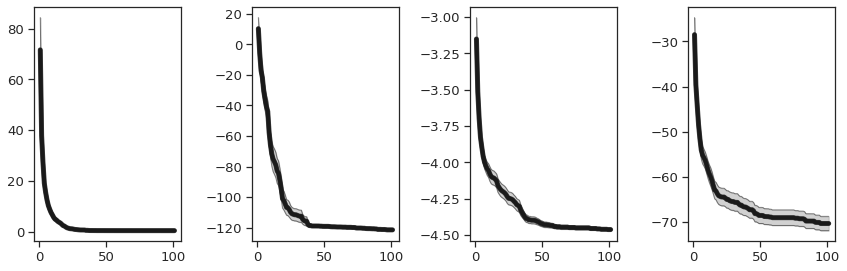

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

plot_trace_sigle_dragonfly('../../benchmarks_known/branin/dragonfly', axes[0])
plot_trace_sigle('../../benchmarks_known/styblinski/dragonfly', axes[1])
plot_trace_sigle('../../benchmarks_known/dejong/dragonfly', axes[2])
plot_trace_sigle('../../benchmarks_known/hyperellips/dragonfly', axes[3])

plt.tight_layout()

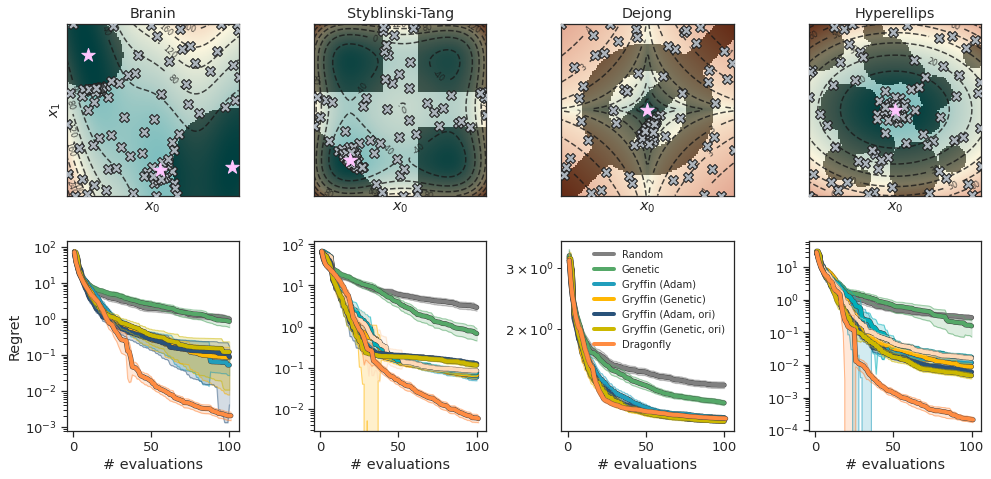

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))


# -------------
# Plot surfaces
# -------------
ax = axes[0,0]
surface = BraninConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/branin/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


ax = axes[0,1]
surface = StyblinskiTangConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/styblinski/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


ax = axes[0,2]
surface = DejongConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/dejong/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)


ax = axes[0,3]
surface = HyperEllipsoidConstr()
plot_constr_surface(surface, ax=ax, N=100)
# example samples
with open('../../benchmarks_known/hyperellips/opt_genetic/results.pkl', 'rb') as content:
    data = pickle.load(content)
X = data[0].loc[:, ['x0', 'x1']]
ax.scatter(X['x0'], X['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)

# -------------
# Plot traces
# -------------
surface = BraninConstr()
plot_trace_sigle('../../benchmarks_known/branin/random/', axes[1,0], color='gray', label='Random',
                 shift=surface.minima[1]['value'])
plot_trace_sigle('../../benchmarks_known/branin/deap/', axes[1,0], color='g', label='Genetic', 
                 shift=surface.minima[1]['value'])
plot_trace_sigle('../../benchmarks_known/branin/opt_adam/', axes[1,0], color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[1]['value'])
plot_trace_sigle('../../benchmarks_known/branin/opt_genetic/', axes[1,0], color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[1]['value'])
# original gryffin runs
plot_trace_sigle('../../benchmarks_known/branin/opt_adam/original/', axes[1,0], color='#29527a', label='Gryffin (Adam, ori)', 
                 shift=surface.minima[1]['value'])
plot_trace_sigle('../../benchmarks_known/branin/opt_genetic/original/', axes[1,0], color='#ccb800', label='Gryffin (Genetic, ori)', 
                 shift=surface.minima[1]['value'])
plot_trace_sigle_dragonfly('../../benchmarks_known/branin/dragonfly/', axes[1,0], color='#ff8c42', label='Dragonfly', 
                  shift=surface.minima[1]['value'])
axes[1,0].set_yscale('log')
        
surface = StyblinskiTangConstr()
plot_trace_sigle('../../benchmarks_known/styblinski/random/', axes[1,1], color='gray', label='Random', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/styblinski/deap/', axes[1,1], color='g', label='Genetic', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/styblinski/opt_adam/', axes[1,1], color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/styblinski/opt_genetic/', axes[1,1], color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'])
# revert to the prior
plot_trace_sigle('../../benchmarks_known/styblinski/opt_adam_prior/', axes[1,1], color='#00afb9', label='Gryffin (Adam, prior)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/styblinski/opt_genetic_prior/', axes[1,1], color='#fed9b7', label='Gryffin (Genetic, prior)', 
                 shift=surface.minima[0]['value'])
# original gryffin runs
plot_trace_sigle('../../benchmarks_known/styblinski/opt_adam/original/', axes[1,1], color='#29527a', label='Gryffin (Adam, ori)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/styblinski/opt_genetic/original/', axes[1,1], color='#ccb800', label='Gryffin (Genetic, ori)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle_dragonfly('../../benchmarks_known/styblinski/dragonfly/', axes[1,1], color='#ff8c42', label='Dragonfly', 
                 shift=surface.minima[0]['value'])
axes[1,1].set_yscale('log')

surface = DejongConstr()
plot_trace_sigle('../../benchmarks_known/dejong/random/', axes[1,2], color='gray', label='Random', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/dejong/deap/', axes[1,2], color='g', label='Genetic', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/dejong/opt_adam/', axes[1,2], color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/dejong/opt_genetic/', axes[1,2], color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'])
# original gryffin runs
plot_trace_sigle('../../benchmarks_known/dejong/opt_adam/original/', axes[1,2], color='#29527a', label='Gryffin (Adam, ori)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/dejong/opt_genetic/original/', axes[1,2], color='#ccb800', label='Gryffin (Genetic, ori)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle_dragonfly('../../benchmarks_known/dejong/dragonfly/', axes[1,2], color='#ff8c42', label='Dragonfly', 
                 shift=surface.minima[0]['value'])
axes[1,2].set_yscale('log')

surface = HyperEllipsoidConstr()
plot_trace_sigle('../../benchmarks_known/hyperellips/random/', axes[1,3], color='gray', label='Random', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/hyperellips/deap/', axes[1,3], color='g', label='Genetic', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/hyperellips/opt_adam/', axes[1,3], color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/hyperellips/opt_genetic/', axes[1,3], color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'])
# revert to the prior
plot_trace_sigle('../../benchmarks_known/hyperellips/opt_adam_prior/', axes[1,3], color='#00afb9', label='Gryffin (Adam, prior)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/hyperellips/opt_genetic_prior/', axes[1,3], color='#fed9b7', label='Gryffin (Genetic, prior)', 
                 shift=surface.minima[0]['value'])
# original gryffin runs
plot_trace_sigle('../../benchmarks_known/hyperellips/opt_adam/original/', axes[1,3], color='#29527a', label='Gryffin (Adam, ori)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_known/hyperellips/opt_genetic/original/', axes[1,3], color='#ccb800', label='Gryffin (Genetic, ori)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle_dragonfly('../../benchmarks_known/hyperellips/dragonfly/', axes[1,3], color='#ff8c42', label='Dragonfly', 
                 shift=surface.minima[0]['value'])
axes[1,3].set_yscale('log')


axes[1,0].set_ylabel('Regret')
for ax in axes[1,:]:
    ax.set_xlabel('# evaluations')

axes[0,0].set_ylabel('$x_1$')
for ax in axes[0,:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('$x_0$')
    
    
axes[0,0].set_title('Branin')
axes[0,1].set_title('Styblinski-Tang')
axes[0,2].set_title('Dejong')
axes[0,3].set_title('Hyperellips')

#axes[1,0].legend(frameon=False)
#axes[1,1].legend(frameon=False, fontsize=12)
axes[1,2].legend(frameon=False, fontsize=10, loc='upper right')
#axes[1,3].legend(frameon=False, fontsize=12)

#handles, labels = axes[1,0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.48))
    
plt.tight_layout()
#plt.savefig('kwn-continuous-benchmark-rh.png', dpi=300)
#fig.savefig('kwn-continuous.pdf', bbox_inches="tight")
#fig.savefig('kwn-continuous.png', dpi=300, bbox_inches="tight")

## Categorical

In [7]:
from benchmark_functions import CatDejongConstr, CatSlopeConstr, CatCamelConstr, CatMichalewiczConstr

In [8]:
def plot_constr_surface_cat(surface, ax=None, mark_min=False):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        
        
    domain = np.arange(surface.num_opts)
    Z = np.zeros((surface.num_opts, surface.num_opts))
    Z_feas = np.empty((surface.num_opts, surface.num_opts))
    X = []
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
            X.append(x)
            loss_value = surface.run(x)
            feas_bool = surface.eval_constr({'x0': x[0], 'x1': x[1]})
            Z[y_index, x_index] = loss_value
            Z_feas[y_index, x_index] = feas_bool
            
    # scale Camel for visualization 
    if type(surface).__name__ == 'CatCamelConstr':
        Z = np.log(Z)

    ax.imshow(Z, origin='lower', cmap = plt.get_cmap('golem'))
    ax.imshow(Z_feas, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
    if mark_min is True:
        X_best = surface.str2array(surface.best)
        _ = ax.scatter(X_best[0], X_best[1], marker='*', s=200, color='#ffc6ff', linewidth=2, zorder=20)
        #_ = ax.scatter(X_best[0], X_best[1], marker='o', s=100, color='none', linewidth=2, edgecolor='#ec091f', zorder=20)
        #_ = ax.scatter(X_best[0], X_best[1], marker='s', s=70, color='none', linewidth=3, edgecolor='#ffc6ff', zorder=20)
        #_ = ax.scatter(X_best[0], X_best[1], marker='*', s=300, color='none', linewidth=3, edgecolor='#ffc6ff', zorder=1)
        
        
        
def unpack_dragonfly(path, best_params):
    all_evals = []
    for i in range(5):
        data_dragon = pickle.load(open(f'{path}dragonfly_{i}/results.pkl', 'rb'))
        for run in data_dragon: 
            num_eval = 1
            for ix, row in run.iterrows():
                param = (row['x0'], row['x1'])
                if param == best_params:
                    break
                else:
                    num_eval+=1
            all_evals.append(num_eval)
            
    return np.array(all_evals)


using only 89 repeats for ../../benchmarks_known/cat-michalewicz/


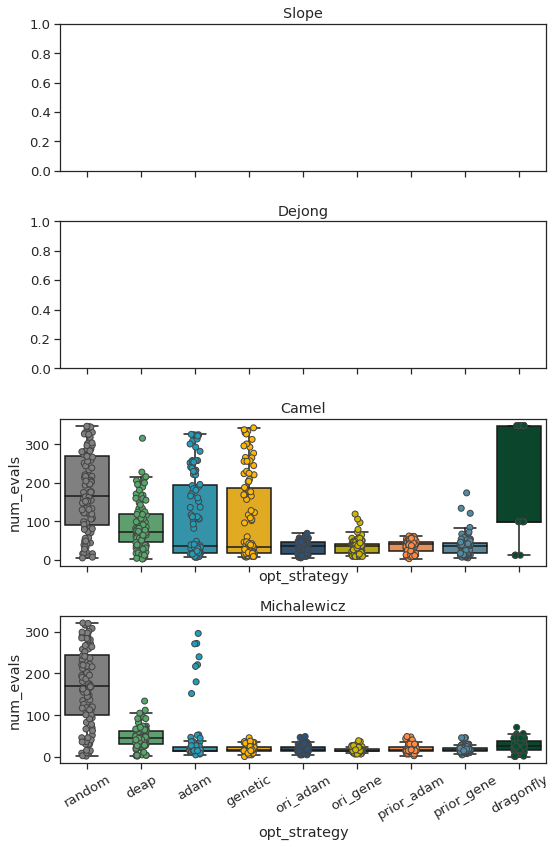

In [11]:
hdsoafwekal;gewo

In [42]:
for name, df in zip(['Slope', 'Dejong', 'Camel', 'Michalewicz'], [df_slope, df_dejong, df_camel, df_mich]):
    print('SURFACE : ', name)
    
    for method in ['random', 'deap', 'adam', 'genetic', 'ori_adam', 'ori_gene', 'dragonfly']:
        
        sub_df = df[df['opt_strategy']==method]
        mean_eval = sub_df['num_evals'].mean()
        std_eval = sub_df['num_evals'].std()
        
        print(f'method : {method}\tmean : {round(mean_eval, 2)}\tstd : {round(std_eval, 2)}')

SURFACE :  Slope
method : random	mean : 157.29	std : 94.73
method : deap	mean : 55.24	std : 25.73
method : adam	mean : 7.24	std : 5.81
method : genetic	mean : 8.5	std : 5.93
method : ori_adam	mean : 11.89	std : 10.33
method : ori_gene	mean : 12.5	std : 9.66
method : dragonfly	mean : 31.32	std : 11.95
SURFACE :  Dejong
method : random	mean : 162.31	std : 96.67
method : deap	mean : 61.45	std : 26.7
method : adam	mean : 14.04	std : 3.37
method : genetic	mean : 17.15	std : 9.46
method : ori_adam	mean : 19.4	std : 7.12
method : ori_gene	mean : 20.29	std : 7.76
method : dragonfly	mean : 33.65	std : 12.11
SURFACE :  Camel
method : random	mean : 174.37	std : 100.33
method : deap	mean : 86.97	std : 60.69
method : adam	mean : 106.25	std : 108.79
method : genetic	mean : 99.73	std : 108.33
method : ori_adam	mean : 32.93	std : 15.7
method : ori_gene	mean : 33.57	std : 20.08
method : dragonfly	mean : nan	std : nan
SURFACE :  Michalewicz
method : random	mean : 167.76	std : 92.71
method : deap	mean : 

PASS


152

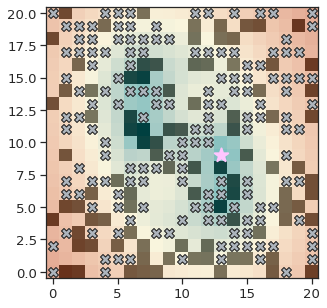

In [39]:
surface = CatCamelConstr()
with open('../../benchmarks_known/cat-camel/opt_adam/results.pkl', 'rb') as content:
    data = pickle.load(content)
    
# surface = CatDejongConstr()
# with open('../../benchmarks_known/cat-dejong/dragonfly/results.pkl', 'rb') as content:
#     data = pickle.load(content)

    
# ------------   
# sanity check
# ------------
allgood = True
n_failed = []
for n, df in enumerate(data):
    x0_arr = df.loc[:, 'x0'].to_numpy()
    x1_arr = df.loc[:, 'x1'].to_numpy()
    for X in np.array([x0_arr, x1_arr]).T:
        feas = surface.eval_constr({'x0':X[0], 'x1':X[1]})
        if feas is False:
            allgood = False
            n_failed.append(n)
            
if allgood is False:
    print(f"FAILED!", sorted(list(set(n_failed))))
else:
    print('PASS')
# ------------


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plot_constr_surface_cat(surface, ax=ax, mark_min=True)

def plot_cat_scatter(data, ax, n=0):
    X_str = data[n].loc[:, ['x0', 'x1']][:-1]  # remove last datapoint
    X_flt = pd.DataFrame([surface.str2array(x) for x in X_str.to_numpy()], columns=X_str.columns)
    ax.scatter(X_flt['x0'], X_flt['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    
n = 0
plot_cat_scatter(data, ax=ax, n=n)
len(data[n])

In [17]:
# sanity check
for df in data:
    x0_arr = df.loc[:, 'x0'].to_numpy()
    x1_arr = df.loc[:, 'x1'].to_numpy()
    for X in np.array([x0_arr, x1_arr]).T:
        feas = surface.eval_constr({'x0':X[0], 'x1':X[1]})
        if feas is False:
            print(f"INFEASIBLE {X}")

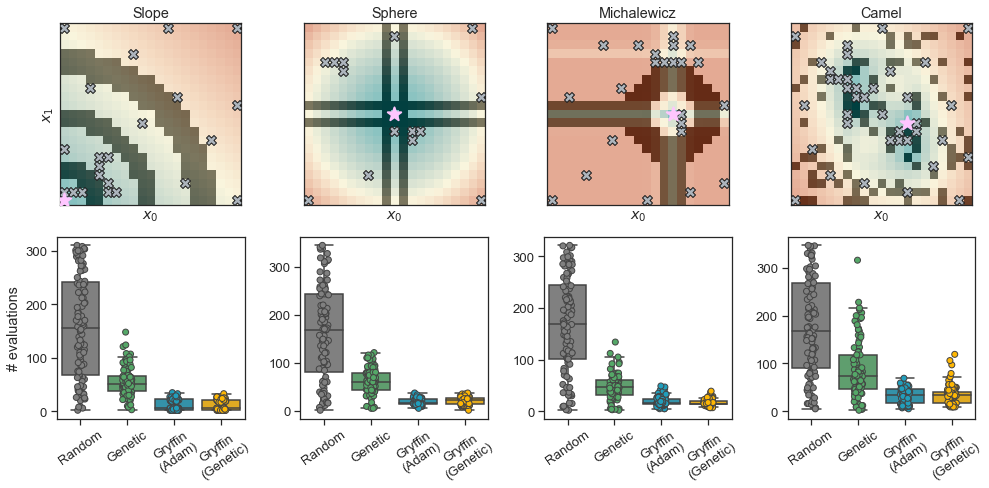

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))

# -------------
# Plot surfaces
# -------------
ax = axes[0,0]
surface = CatSlopeConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-slope/opt_adam/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=3)


ax = axes[0,1]
surface = CatDejongConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-dejong/opt_adam/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=3)


ax = axes[0,2]
surface = CatMichalewiczConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-michalewicz/opt_adam/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=8)


ax = axes[0,3]
surface = CatCamelConstr()
plot_constr_surface_cat(surface, ax=ax, mark_min=True)
# example samples
with open('../../benchmarks_known/cat-camel/opt_adam/results.pkl', 'rb') as content:
    data = pickle.load(content)
plot_cat_scatter(data, ax=ax, n=0)


# -------------
# Plot boxplots
# -------------
plot_eval_comparison('../../benchmarks_known/cat-slope', ax=axes[1,0])
plot_eval_comparison('../../benchmarks_known/cat-dejong', ax=axes[1,1])
plot_eval_comparison('../../benchmarks_known/cat-michalewicz', ax=axes[1,2])
plot_eval_comparison('../../benchmarks_known/cat-camel', ax=axes[1,3])

for ax in axes[1,:]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(['Random', 'Genetic', 'Gryffin\n(Adam)', 'Gryffin\n(Genetic)'], rotation=35)

for ax in axes[0,:]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('$x_0$')
    
axes[1,0].set_ylabel('# evaluations')
axes[0,0].set_ylabel('$x_1$')
    
axes[0,0].set_title('Slope')
axes[0,1].set_title('Sphere')
axes[0,2].set_title('Michalewicz')
axes[0,3].set_title('Camel')
    
plt.tight_layout()
fig.savefig('kwn-categorical.pdf', bbox_inches="tight")
fig.savefig('kwn-categorical.png', dpi=300, bbox_inches="tight")

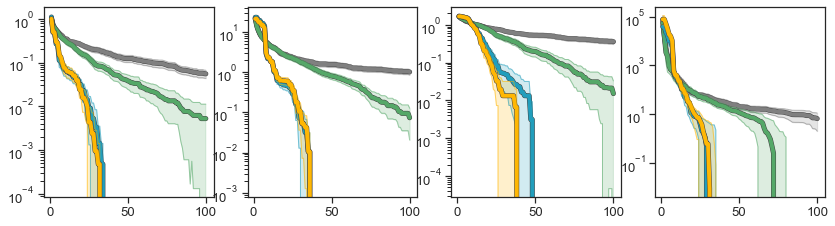

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 3.5))


benchmark = 'cat-slope'
ax = axes[0]
surface = CatSlopeConstr()
ybest = surface.run(list(surface.best))

plot_trace_sigle(f'../../benchmarks_known/{benchmark}/random', ax, color='gray', label='Random',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/deap', ax, color='g', label='Genetic',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)',
                 shift=ybest, categorical=True)


benchmark = 'cat-dejong'
ax = axes[1]
surface = CatDejongConstr()
ybest = surface.run(list(surface.best))

plot_trace_sigle(f'../../benchmarks_known/{benchmark}/random', ax, color='gray', label='Random',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/deap', ax, color='g', label='Genetic',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)',
                 shift=ybest, categorical=True)


benchmark = 'cat-michalewicz'
ax = axes[2]
surface = CatMichalewiczConstr()
ybest = surface.run(list(surface.best))

plot_trace_sigle(f'../../benchmarks_known/{benchmark}/random', ax, color='gray', label='Random',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/deap', ax, color='g', label='Genetic',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)',
                 shift=ybest, categorical=True)


benchmark = 'cat-camel'
ax = axes[3]
surface = CatCamelConstr()
ybest = surface.run(list(surface.best))

plot_trace_sigle(f'../../benchmarks_known/{benchmark}/random', ax, color='gray', label='Random',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/deap', ax, color='g', label='Genetic',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/opt_adam/', ax, color='#219ebc', label='Gryffin (Adam)',
                 shift=ybest, categorical=True)
plot_trace_sigle(f'../../benchmarks_known/{benchmark}/opt_genetic/', ax, color='#ffb703', label='Gryffin (Genetic)',
                 shift=ybest, categorical=True)


for i in range(4):
    axes[i].set_yscale('log')

0.0

In [130]:
surface = CatMichalewiczConstr()
ybest = surface.run(list(surface.best))
ybest

-1.8010702893119994

In [59]:
l1 = [[4,5,6], [11,22,33]]
l2 = [[0,1,2], [44,55,66]]

[l1, l2]

[[[4, 5, 6], [11, 22, 33]], [[0, 1, 2], [44, 55, 66]]]

In [60]:
np.concatenate([l1, l2])

array([[ 4,  5,  6],
       [11, 22, 33],
       [ 0,  1,  2],
       [44, 55, 66]])

In [5]:
# check the fraction of feasible space for each categorical surface
all_params = []
x0s = [f'x_{i}' for i in range(21)]
x1s = [f'x_{i}' for i in range(21)]

for x0 in x0s:
    for x1 in x1s:
        all_params.append({'x0': x0, 'x1': x1})
        

In [11]:
# dejong
surface = CatDejongConstr()

feas_count = 0
for param in all_params:
    if surface.is_feasible(param):
        feas_count += 1
        
print(feas_count, feas_count/441)

361 0.81859410430839


In [12]:
# michalewicz
surface = CatMichalewiczConstr()

feas_count = 0
for param in all_params:
    if surface.is_feasible(param):
        feas_count += 1
        
print(feas_count, feas_count/441)

323 0.7324263038548753


In [13]:
# camel
surface = CatCamelConstr()

feas_count = 0
for param in all_params:
    if surface.is_feasible(param):
        feas_count += 1
        
print(feas_count, feas_count/441)

347 0.7868480725623582


In [14]:
# slope
surface = CatSlopeConstr()

feas_count = 0
for param in all_params:
    if surface.is_feasible(param):
        feas_count += 1
        
print(feas_count, feas_count/441)

311 0.7052154195011338
